In [1]:
from neo import Block
from neo.io import Spike2IO, NeoMatlabIO
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
from kaveh.behavioral.oculomotor.trial import trial
from kaveh.sorting import spikesorter
from kaveh.toolbox import find_file
from kaveh.plots import axvlines
import numpy as np
from matplotlib import pyplot as plt
from smr import File
import csv
import os
import gc

In [71]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
# These are Buckley files with the following event structure:
# Event 0
# Event 1
# Event 2
# Event 3 : Trial onset
# Event 4 : Primary target presentation in adaptation trials
# Event 5 : Corrective target presentation in adaptation trials
# Event 6 : Divide each trial into its target jumps
# Event 7 : 
buckley_files_correct_events = ['B082107_1340_List.smr', #yes
'B090407_1526_List.smr', # yes
# 'B091208_1545_List.smr', # No done
# 'B091608_1208_List.smr', # No done
'B091707_1414_List.smr', # No done
'B091908_1_1500_List.smr', # No done
'B091908_2_1550_List.smr', # No done
'B093008_1149_List.smr', # No done
'B100308_2_1403_List.smr', # No done
'W091008_1241_List.smr', # No done
'W091208_1337_List.smr', # No done: bimodal cs-on
'W120208_1_1418_List.smr', # No done
'W120508_1_1420_List.smr', # No done
'W120508_2_1628_List.smr'] # No

# f_name = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_25deg/B082107/B082107_1340_List.smr'
# f_name = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_25deg/B110807/B110807_1632_List.smr'

In [3]:
for bf in buckley_files_correct_events:
    f_name = find_file(bf, '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt')
    f_name_csv = find_file(bf+'.pkl.csv', '../data/david_neurons')
    print(f_name)
    print(f_name_csv)
    neo_reader = Spike2IO(filename=f_name)
    neo_data = neo_reader.read()
    data_block = neo_data[0]
    seg = data_block.segments[0]
    events = seg.events
    # Load events
    labels = np.unique(events[-1].labels)

    event_times = [0]*labels.size

    for i, label in enumerate(labels):
        event_times[i] = events[-1].times[events[-1].labels == label]

    # Load eye data
    HE = seg.analogsignals[0].as_array()
    t_HE = seg.analogsignals[0].times;

    VE = seg.analogsignals[1].as_array()
    t_VE = seg.analogsignals[1].times

    HT = seg.analogsignals[2].as_array()
    t_HT = seg.analogsignals[2].times

    VT = seg.analogsignals[3].as_array()
    t_VT = seg.analogsignals[3].times

    eye_fs = seg.analogsignals[0].sampling_rate

    # Load voltage
    signal = seg.analogsignals[-1].as_array()
    t_signal = seg.analogsignals[-1].times
    signal_fs = seg.analogsignals[-1].sampling_rate

    # Load cs times from csGUI csv files

    with open(f_name_csv, 'r') as csv_f:
        reader = csv.reader(csv_f)
        csv_content = np.array(list(reader), dtype=np.int64)

    cs_indices = np.squeeze(csv_content[np.where(csv_content[:,1] == 1), 0])
    cs_times = t_signal[cs_indices]
    cs_times.shape
    # create a list of trials based on wether events indicating primary target presentations 
    # in adaptation trials exist or not (this is the way most of 2010_Adapt files are structured)
    from kaveh.behavioral.oculomotor.trial import trial

    trial_num = 0
    start_time = event_times[3][trial_num]
    end_time = event_times[3][trial_num + 1]
    trials = []

    while np.any(np.where((event_times[4] < end_time) & (event_times[4] > start_time))):
        primary_target_times = event_times[4][np.where((event_times[4] < end_time) & (event_times[4] > start_time))]
        corrective_target_times = event_times[5][np.where((event_times[5] < end_time) & (event_times[5] > start_time))]
        trial_signal = signal[(t_signal > start_time) & (t_signal <= end_time)]
        trial_t_signal = t_signal[(t_signal > start_time) & (t_signal <= end_time)]
        trial_cs_times = cs_times[(cs_times > start_time) & (cs_times <= end_time)]

        trial_HT = HT[(t_HT > start_time) & (t_HT <= end_time)]
        trial_t_HT = t_HT[(t_HT > start_time) & (t_HT <= end_time)]

        trial_VT = VT[(t_VT > start_time) & (t_VT <= end_time)]
        trial_t_VT = t_VT[(t_VT > start_time) & (t_VT <= end_time)]

        trial_HE = HE[(t_HE > start_time) & (t_HE <= end_time)]
        trial_t_HE = t_HE[(t_HE > start_time) & (t_HE <= end_time)]

        trial_VE = VE[(t_VE > start_time) & (t_VE <= end_time)]
        trial_t_VE = t_VE[(t_VE > start_time) & (t_VE <= end_time)]

        trials = trials + [trial(trial_num, start_time, end_time, primary_target_times,
                                 corrective_target_times, cs_times=trial_cs_times,
                                 HT=trial_HT, t_HT= trial_t_HT, VT=trial_VT, t_VT=trial_t_VT,
                                 HE=trial_HE, t_HE= trial_t_HE, VE=trial_VE, t_VE=trial_t_VE,
                                 signal=trial_signal, t_signal=trial_t_signal)]
        trial_num = trial_num + 1
        if trial_num < len(event_times[3]) - 1:
            start_time = event_times[3][trial_num]
            end_time = event_times[3][trial_num + 1]
        else:
            break


    import quantities as pq
    cs_range = pq.quantity.Quantity(0.250, 's')

    fired_complex_spikes_corrective = np.zeros((len(trials[0:-2]), 16))
    fired_complex_spikes_primary = np.zeros((len(trials[0:-2]), 16))


    trial_num = 0
    for i, trial in enumerate(trials[0:-2]):
    # trial = trials[trial_num]
    #     print(trial.primary_target_dir)
    #     print(trial.corrective_target_dir)
        for j, ctt in enumerate(trial.corrective_target_times):
            fired_complex_spikes_corrective[i][j] = np.count_nonzero(np.where(np.logical_and(trial.cs_times < ctt+cs_range, trial.cs_times > ctt )))
        for j, ptt in enumerate(trial.primary_target_times):
            next_corrective = trial.corrective_target_times[j] + pq.quantity.Quantity(0.050, 's')
            if j != np.where(trial.corrective_target_times >= ptt)[0][0] :
                raise ValueError('primary - corrective index mismatch: ptti = {}'.format(j))

            fired_complex_spikes_primary[i][j] = np.count_nonzero(np.where(np.logical_and(trial.cs_times < ptt +
                                                                                          min(cs_range, next_corrective),
                                                                                          trial.cs_times > ptt )))


    if trials[0].primary_target_dir.size != trials[0].corrective_target_dir.size: 
        raise ValueError('Different number of directions in primary and corrective target presentations')
    directions_primary = np.unique(trials[0].primary_target_dir)
    dir_idx_primary = {}
    for d in directions_primary:
        dir_idx_primary[d] = np.where(trials[0].primary_target_dir == d)[0]

    directions_corrective = np.unique(trials[0].corrective_target_dir)
    dir_idx_corrective = {}
    for d in directions_corrective:
        dir_idx_corrective[d] = np.where(trials[0].corrective_target_dir == d)[0]

    cs_rate_primary = {}
    cs_rate_corrective = {}
    for d in dir_idx_primary:
        cs_rate_primary[d] = np.sum(fired_complex_spikes_primary[:, dir_idx_primary[d]])
    for d in dir_idx_corrective:
        cs_rate_corrective[d] = np.sum(fired_complex_spikes_corrective[:, dir_idx_corrective[d]])


    import operator
    cs_on = max(cs_rate_corrective.items(), key=operator.itemgetter(1))[0]
    cs_rate_corrective_cs_on_aligned = {}
    for key, value in cs_rate_corrective.items():
        cs_rate_corrective_cs_on_aligned[key - cs_on] = value

    # cs_on = max(cs_rate_corrective.items(), key=operator.itemgetter(1))[0]
    cs_rate_primary_cs_on_aligned = {}
    for key, value in cs_rate_primary.items():
        cs_rate_primary_cs_on_aligned[key - cs_on] = value

    [x_cor,y_cor] = zip(*sorted(cs_rate_corrective_cs_on_aligned.items()))
    [x_prim,y_prim] = zip(*sorted(cs_rate_primary_cs_on_aligned.items()))

    data = [0]*4
    data[0] = x_cor
    data[1] = y_cor
    data[2] = x_prim
    data[3] = y_prim
    # Save tuning to csv
    with open(f_name_csv + '.tuning.csv', 'w') as the_file:
        csv.register_dialect("custom", delimiter=",", skipinitialspace=True)
        writer = csv.writer(the_file, dialect="custom")
        for tup in data:
            writer.writerow(tup)

/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_25deg/B082107/B082107_1340_List.smr
../data/david_neurons/B082107/B082107_1340_List.smr.pkl.csv
/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_25deg/B090407/B090407_1526_List.smr
../data/david_neurons/B090407/B090407_1526_List.smr.pkl.csv
/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_25deg/B091707/B091707_1414_List.smr
../data/david_neurons/B091707/B091707_1414_List.smr.pkl.csv
/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_12deg/B091908_1/B091908_1_1500_List.smr
../data/david_neurons/B091908_1/B091908_1_1500_List.smr.pkl.csv
/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_12deg/B091908_2/B091908_2_1550_List.smr
../data/david_neurons/B091908_2/B091908_2_1550_List.smr.pkl.csv
/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_12deg/B093008/B093008_1149_List.smr
../data/david_neurons/B093008/B093008_1149_List.smr.pkl.csv
/mnt/p

In [63]:
tunings = []
stim_tunings = []
for bf in buckley_files_correct_events:
    f_name_csv = find_file(bf+'.pkl.csv', '../data/david_neurons')
    with open(f_name_csv + '.tuning.csv', 'r') as csv_f:
        reader = csv.reader(csv_f)
        csv_content = list(reader)
        csv_content = np.array(csv_content, dtype='double')
        # print(np.array(csv_content, dtype='double'))
    zero_idx = np.where(np.array(csv_content, dtype='double')[0,:] == 0)[0]
    tunings.append(np.roll(csv_content, 3-zero_idx , axis=1)[1,:])
    stim_tunings.append(np.roll(csv_content, 3-zero_idx , axis=1)[3,:])
    print(np.roll(csv_content, 3-zero_idx , axis=1))

#     print(csv_content)

    print('-------------------------------------------------------------------------------------')

[[225. 270. -45.   0.  45.  90. 135. 180.]
 [ 10.   5.  14.  29.  14.  10.   5.   3.]
 [225. 270. -45.   0.  45.  90. 135. 180.]
 [  6.   9.   8.  17.  15.   6.   6.   6.]]
-------------------------------------------------------------------------------------
[[225. 270. 315.   0.  45.  90. 135. 180.]
 [  0.   4.   2.   4.   2.   2.   1.   2.]
 [225. 270. 315.   0.  45.  90. 135. 180.]
 [  1.   2.   3.   1.   2.   3.   1.   4.]]
-------------------------------------------------------------------------------------
[[-135.  -90.  -45.    0.   45.   90.  135.  180.]
 [   2.    3.   15.   15.   10.    5.    6.    2.]
 [-135.  -90.  -45.    0.   45.   90.  135.  180.]
 [   3.    8.   13.    9.    8.    9.   11.    8.]]
-------------------------------------------------------------------------------------
[[-135.  -90.  -45.    0. -315. -270. -225. -180.]
 [   1.    2.    5.    8.    2.    3.    0.    2.]
 [-135.  -90.  -45.    0. -315. -270. -225. -180.]
 [   4.    1.    7.    9.    4.    4. 

<IPython.core.display.Javascript object>


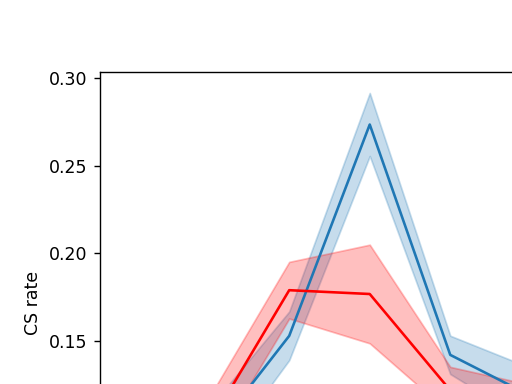

([<matplotlib.axis.XTick at 0x7f0d14081810>,
 <a list of 8 Text xticklabel objects>)

In [80]:
tunings = np.array(tunings)

row_sum = tunings.sum(axis=1)
tunings_norm = tunings/row_sum[:, np.newaxis]

tunings_mean = np.mean(tunings_norm, axis = 0)

tunings_sd = np.std(tunings_norm, axis = 0)/np.sqrt(11)

x = [-135, -90, -45, 0, 45, 90, 135, 180]
l = plt.plot(x, tunings_mean)
plt.fill_between(x, tunings_mean - tunings_sd, tunings_mean + tunings_sd, color=l[0].get_color(), alpha=0.25)
plt.xticks(x,x)

In [82]:
plt.xlabel('Degrees from CS-ON')
plt.ylabel('CS rate')

Text(42.4028,0.5,u'CS rate')

In [84]:
plt.savefig('../data/plots/12neurons_adapt_2010.png')

In [81]:
stim_tunings = np.array(stim_tunings)

row_sum = stim_tunings.sum(axis=1)
stim_tunings_norm = stim_tunings/row_sum[:, np.newaxis]

stim_tunings_mean = np.mean(stim_tunings_norm, axis = 0)

stim_tunings_sd = np.std(stim_tunings_norm, axis = 0)/np.sqrt(11)

# x = np.arange(0,8)
# plt.figure()
l = plt.plot(x, stim_tunings_mean, 'r')
plt.fill_between(x, stim_tunings_mean - stim_tunings_sd, stim_tunings_mean + stim_tunings_sd, color=l[0].get_color(), alpha=0.25)


In [79]:
plt.savefig('../data/plots/12neurons_adapt_2010.png')